In [1]:
##
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import cv2
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import argparse


### dataset ###
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.
from sklearn.model_selection import KFold
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader


from PIL import Image
import cv2


##
import torch
import torch.nn.functional as F

### etc ###
from tqdm import tqdm
from sklearn.manifold import TSNE
from glob import glob
#time
import time


from ipywidgets import interact, IntSlider

from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter, distance_transform_edt
from scipy.ndimage.morphology import binary_erosion



/tmp/ipykernel_974498/1033992249.py:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


In [2]:
BATCH_SIZE = 8
NUM_EPOCHS = 2
LEARNING_RATE = 0.0001

In [3]:
# dataset load. split
# testset load


train_list = glob("/ssd2/colono/data/TrainDataset/image/*.png")
train_mask_list = glob("/ssd2/colono/data/TrainDataset/mask/*.png")

# test_list = glob("/ssd2/colono/data/TestDataset/CVC-ColonDB/images/*.png")
# test_mask_list = glob("/ssd2/colono/data/TestDataset/CVC-ColonDB/masks/*.png")



# 정렬
train_list.sort()
train_mask_list.sort()

# test_list.sort()
# test_mask_list.sort()


In [4]:
# train valid split
# shuffle 없이
# train, test, valid split 8:1:1

train_list, rest_list, train_mask_list, rest_mask_list = train_test_split(train_list, train_mask_list, test_size=0.2, random_state=42)

valid_list, test_list, valid_mask_list, test_mask_list = train_test_split(rest_list, rest_mask_list, test_size=0.5, random_state=42)



In [5]:
# 데이터셋 수 확인.
print("train_list : ", len(train_list))
print("valid_list : ", len(valid_list))
print("test_list : ", len(test_list))


train_list :  1160
valid_list :  145
test_list :  145


In [6]:
## dataset 제작
class ColonoscopyDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None, mask_transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx])
        mask = Image.open(self.mask_list[idx])

        if self.transform:
            img = self.transform(img)
            mask = self.mask_transform(mask)
        
        # 만약 마스크가 1채널이 아니라면, 1채널로 변경
        if mask.shape[0] != 1:
            # 하나로 압축. 3채널 중 하나라도 0보다 크면 1 표시.
            mask = mask[0].unsqueeze(0)
            mask[mask > 0] = 1
        
        return img, mask

In [7]:
# mask를 어떻게 업샘플 시킬지 찾아야함.

img_transform = transforms.Compose([
    transforms.Resize((352, 352)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((352, 352),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])


train_dataset = ColonoscopyDataset(train_list, train_mask_list, transform=img_transform, mask_transform=mask_transform)
valid_dataset = ColonoscopyDataset(valid_list, valid_mask_list, transform=img_transform, mask_transform=mask_transform)
test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)

In [8]:
# dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


torch.Size([8, 3, 352, 352]) torch.Size([8, 1, 352, 352])


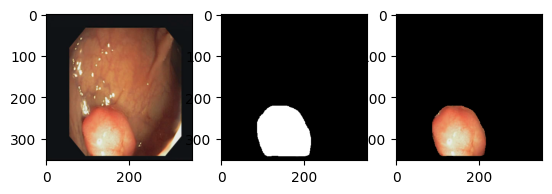

In [9]:
# data check
for img, mask in train_loader:
    print(img.shape, mask.shape)
    break

# visualize
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(mask[0][0], cmap='gray')

#둘의 곱
plt.subplot(1, 3,3)
plt.imshow( (img[0] * mask[0][0]).permute(1, 2, 0), cmap='gray')

plt.show()

torch.Size([8, 3, 352, 352]) torch.Size([8, 1, 352, 352])


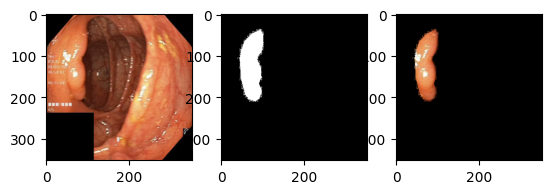

In [10]:
# data check
for img, mask in valid_loader:
    print(img.shape, mask.shape)
    break

# visualize
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(mask[0][0], cmap='gray')

#둘의 곱
plt.subplot(1, 3,3)
plt.imshow( (img[0] * mask[0][0]).permute(1, 2, 0), cmap='gray')

plt.show()

In [11]:
# https://velog.io/@pre_f_86/UNET-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        def cbr(in_channels, out_channels, kernel_size = 3, stride = 1):
            layers = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
            return layers
        
        self.enc1_1 = cbr(3,64)
        self.enc1_2 = cbr(64,64)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.enc2_1 = cbr(64,128)
        self.enc2_2 = cbr(128,128)
        self.pool2 = nn.MaxPool2d(2,2)

        self.enc3_1 = cbr(128,256)
        self.enc3_2 = cbr(256,256)
        self.pool3 = nn.MaxPool2d(2,2)

        self.enc4_1 = cbr(256,512)
        self.enc4_2 = cbr(512,512)
        self.pool4 = nn.MaxPool2d(2,2)

        self.enc5_1 = cbr(512,1024)
        self.enc5_2 = cbr(1024,1024)

        self.unpool4 = nn.ConvTranspose2d(1024,512,2,2) ### 해당 부분 수정?
        self.dec4_2 = cbr(1024,512)
        self.dec4_1 = cbr(512,512)

        self.unpool3 = nn.ConvTranspose2d(512,256,2,2)
        self.dec3_2 = cbr(512,256)
        self.dec3_1 = cbr(256,256)

        self.unpool2 = nn.ConvTranspose2d(256,128,2,2)
        self.dec2_2 = cbr(256,128)
        self.dec2_1 = cbr(128,128)

        self.unpool1 = nn.ConvTranspose2d(128,64,2,2)
        self.dec1_2 = cbr(128,64)
        self.dec1_1 = cbr(64,64)

        self.result = nn.Sequential(
            nn.Conv2d(64,1,3,1,1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        #print(x.shape)
        enc1_1 = self.enc1_1(x) 
        enc1_2 = self.enc1_2(enc1_1) 
        pool1 = self.pool1(enc1_2) 
        
        
        enc2_1 = self.enc2_1(pool1) 
        enc2_2 = self.enc2_2(enc2_1) 
        pool2 = self.pool2(enc2_2) 
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1) 
        pool3 = self.pool3(enc3_2)        
        
        enc4_1 = self.enc4_1(pool3) 
        enc4_2 = self.enc4_2(enc4_1) 
        pool4 = self.pool4(enc4_2) 
        
        enc5_1 = self.enc5_1(pool4) 
        enc5_2 = self.enc5_2(enc5_1) 
        
        unpool4 = self.unpool4(enc5_2)

        #print(unpool4.shape, enc4_2.shape)
        ### 홀수로 인한 사이즈 맞춤. # 32,32 -> 33,33 
        unpool4 = F.interpolate(unpool4, size=(enc4_2.size(2), enc4_2.size(3)), mode='bilinear', align_corners=True)
        ###
        #print(unpool4.shape, enc4_2.shape)
                
        dec4_2 = self.dec4_2(torch.cat((unpool4,enc4_2),1))
        dec4_1 = self.dec4_1(dec4_2) 
        
        unpool3 = self.unpool3(dec4_1) 
        dec3_2 = self.dec3_2(torch.cat((unpool3,enc3_2),1)) 
        dec3_1 = self.dec3_1(dec3_2) 
        
        unpool2 = self.unpool2(dec3_1) 
        dec2_2 = self.dec2_2(torch.cat((unpool2,enc2_2),1)) 
        dec2_1 = self.dec2_1(dec2_2) 
        
        unpool1 = self.unpool1(dec2_1) 
        dec1_2 = self.dec1_2(torch.cat((unpool1,enc1_2),1))
        dec1_1 = self.dec1_1(dec1_2) 

        out = self.result(dec1_1)
        return out 

sample_model = UNet()
sample_img = F.interpolate(img, scale_factor=1.0, mode='bilinear', align_corners=True)
sample_mask = F.interpolate(mask, scale_factor=1.0, mode='nearest')

sample_output = sample_model(sample_img[0].unsqueeze(0))
print(sample_output.shape)

torch.Size([1, 1, 352, 352])


In [12]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    torch.cuda.empty_cache()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()


    train_loss = []
    valid_loss = []
    start_time = time.time()
    size_rates = [0.75, 1, 1.25]
    

    
    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = []
        valid_epoch_loss = []
            
        for img, mask in train_loader:
            img = img.cuda()
            mask = mask.cuda()
            for rate in size_rates:
                # augmentation
                if rate != 1:
                    img_in = F.interpolate(img, scale_factor=rate, mode='bilinear', align_corners=True)
                    mask_in = F.interpolate(mask, scale_factor=rate, mode='nearest')
                pred_mask = model(img_in)
                loss = criterion(pred_mask, mask_in)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if rate == 1:
                    train_epoch_loss.append(loss.item())
                    
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {np.mean(train_epoch_loss)}, elapsed time: {time.time() - start_time}")
        # save model
        if epoch % 5 == 0 or epoch == (num_epochs - 1) :
            torch.save(model.state_dict(), f"./checkpoint/unet_{epoch}.pth")
        train_loss.append(np.mean(train_epoch_loss))
        
        # validation
        model.eval()
        with torch.no_grad():
            for img, mask in valid_loader:
                img = img.cuda()
                mask = mask.cuda()

                pred_mask = model(img)
                loss = criterion(pred_mask, mask)
            valid_epoch_loss.append(loss.item())
            print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {np.mean(valid_epoch_loss)}")
        valid_loss.append(np.mean(valid_epoch_loss))
            
    return model, train_loss, valid_loss


model = UNet().cuda()
model, train_loss, valid_loss = train(model, train_loader, valid_loader, NUM_EPOCHS, LEARNING_RATE)



Epoch [0/2], Loss: 0.32918243130733227, elapsed time: 86.81759452819824
Epoch [0/2], Validation Loss: 0.23264896869659424
Epoch [1/2], Loss: 0.27895237865119143, elapsed time: 175.86893486976624
Epoch [1/2], Validation Loss: 0.21929170191287994


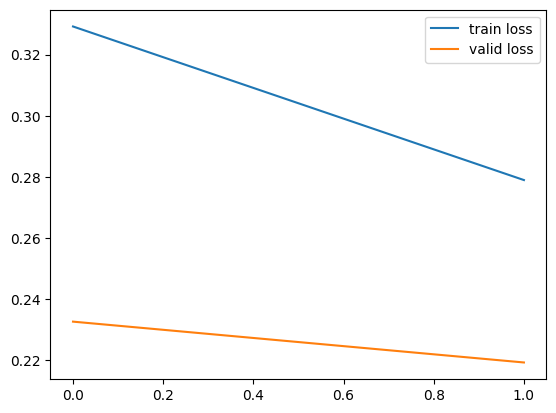

In [13]:
# visualize
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
plt.legend()
plt.show()


In [19]:
def alignment_term(dFM, dGT):
    mu_FM = np.mean(dFM)
    mu_GT = np.mean(dGT)
    
    align_FM = dFM - mu_FM
    align_GT = dGT - mu_GT
    
    align_matrix = 2 * (align_GT * align_FM) / (align_GT**2 + align_FM**2 + np.finfo(float).eps)
    return align_matrix

def enhanced_alignment_term(align_matrix):
    return ((align_matrix + 1)**2) / 4

def emeasure(FM, GT):
    FM = FM.astype(bool)
    GT = GT.astype(bool)
    
    dFM = FM.astype(float)
    dGT = GT.astype(float)
    
    if dGT.sum() == 0:  # Completely black GT
        enhanced_matrix = 1.0 - dFM
    elif np.logical_not(dGT).sum() == 0:  # Completely white GT
        enhanced_matrix = dFM
    else:
        align_matrix = alignment_term(dFM, dGT)
        enhanced_matrix = enhanced_alignment_term(align_matrix)
        
    score = enhanced_matrix.sum() / (FM.size - 1 + np.finfo(float).eps)
    return score

In [20]:

def object_similarity(prediction, GT):
    """
    Compute similarity for a given region (foreground or background).
    """
    if prediction.size == 0:
        return 0
    x = np.mean(prediction[GT])
    sigma_x = np.std(prediction[GT])
    score = 2.0 * x / (x**2 + 1.0 + sigma_x + np.finfo(float).eps)
    return score



def s_object(prediction, GT):
    """
    Compute the object similarity between the prediction and the ground truth.
    """
    prediction_fg = prediction.copy()
    prediction_fg[np.logical_not(GT)] = 0
    o_fg = object_similarity(prediction_fg, GT)
    
    prediction_bg = 1.0 - prediction
    prediction_bg[GT] = 0
    o_bg = object_similarity(prediction_bg, np.logical_not(GT) )
    
    u = np.mean(GT)
    q = u * o_fg + (1 - u) * o_bg
    return q


def centroid(GT):
    """
    Calculate the centroid of the binary ground truth image.
    """
    rows, cols = np.where(GT)
    if len(rows) == 0:
        return GT.shape[1] // 2, GT.shape[0] // 2
    return np.mean(cols), np.mean(rows)

def divide_gt(GT, X, Y):
    """
    Divide the ground truth into four regions based on its centroid.
    """
    h, w = GT.shape
    regions = [
        GT[:int(Y), :int(X)],  # Top-left
        GT[:int(Y), int(X):],  # Top-right
        GT[int(Y):, :int(X)],  # Bottom-left
        GT[int(Y):, int(X):]   # Bottom-right
    ]
    weights = [np.sum(region) / GT.size for region in regions]
    return regions, weights



def s_region(prediction, GT):
    """
    Compute the region similarity between the prediction and the ground truth.
    """
    X, Y = centroid(GT)
    gt_parts, w_parts = divide_gt(GT, X, Y)
    pred_parts = divide_prediction(prediction, X, Y)
    
    q = sum(w * ssim(pred, gt, data_range=1.0) 
            for pred, gt, w in zip(pred_parts, gt_parts, w_parts))
    return q





def divide_prediction(prediction, X, Y):
    """
    Divide the prediction into four regions based on the centroid of the ground truth.
    """
    h, w = prediction.shape
    regions = [
        prediction[:int(Y), :int(X)],  # Top-left
        prediction[:int(Y), int(X):],  # Top-right
        prediction[int(Y):, :int(X)],  # Bottom-left
        prediction[int(Y):, int(X):]   # Bottom-right
    ]
    return regions


####

def structure_measure(prediction, GT):
    """
    Compute the similarity score between the prediction and ground truth.
    
    Args:
    prediction (np.ndarray): The predicted foreground map, values in [0, 1].
    GT (np.ndarray): The binary ground truth, type bool.
    
    Returns:
    float: The computed similarity score.
    """
    prediction = prediction.astype(float)
    GT = GT.astype(bool)
    
    # Input checks
    if not prediction.dtype == np.float64:
        raise ValueError("The prediction should be double type...")
    if prediction.max() > 1 or prediction.min() < 0:
        raise ValueError("The prediction should be in the range of [0 1]...")
    if GT.dtype != bool:
        raise ValueError("GT should be logical type...")
    
    y = np.mean(GT)
    
    if y == 0:  # GT is completely black
        x = np.mean(prediction)
        Q = 1.0 - x
    elif y == 1:  # GT is completely white
        x = np.mean(prediction)
        Q = x
    else:
        alpha = 0.5
        # Assuming S_object and S_region are defined elsewhere
        Q = alpha * s_object(prediction, GT) + (1 - alpha) * s_region(prediction, GT)
        Q = max(Q, 0)  # Ensure Q is non-negative
    
    return Q

In [21]:
def original_WFb(FG, GT):
    """
    Compute the Weighted F-beta score between the foreground map and the ground truth.
    """
    FG = FG.astype(float)
    GT = GT.astype(bool)
    
    if not FG.dtype == np.float64:
        raise ValueError("FG should be of type: double")
    if FG.max() > 1 or FG.min() < 0:
        raise ValueError("FG should be in the range of [0, 1]")
    if not GT.dtype == bool:
        raise ValueError("GT should be of type: logical")
    
    dGT = GT.astype(float)
    E = np.abs(FG - dGT)
    
    Dst, IDXT = distance_transform_edt(1-GT, return_indices=True)
    K = gaussian_filter(E, sigma=5)
    Et = E.copy()
    Et[ np.logical_not(GT) ] = Et[tuple(IDXT[:, np.logical_not(GT)])]
    EA = gaussian_filter(Et, sigma=5)
    MIN_E_EA = np.where(GT & (EA < E), EA, E)
    
    B = np.ones(GT.shape)
    B[ np.logical_not(GT) ] = 2.0 - np.exp(np.log(1 - 0.5) / 5 * Dst[~GT])
    Ew = MIN_E_EA * B
    
    TPw = np.sum(dGT) - np.sum(Ew[GT])
    FPw = np.sum(Ew[ np.logical_not(GT) ])
    
    R = 1 - np.mean(Ew[GT])  # Weighted Recall
    P = TPw / (np.finfo(float).eps + TPw + FPw)  # Weighted Precision
    
    Q = (2) * (R * P) / (np.finfo(float).eps + R + P)  # Beta=1
    return Q

In [22]:
def get_metric(res,gt):
    # dice
    intersection = np.logical_and(res, gt)
    dice = 2. * intersection.sum() / (res.sum() + gt.sum())
    # iou
    union = np.logical_or(res, gt)
    iou = intersection.sum() / union.sum()
    
    #MAE for pixel accuracy
    mae = np.abs(res - gt).mean()
    
    #weighted dice metric
    wfb = original_WFb(res,gt)
    
    
    #Enhanced-alignment Measure for Binary Foreground Map Evaluation
    # 상관 계수
    e_m = emeasure(res,gt)
    
    #Structure measure (: Structure-measure: A new way to evaluate foreground maps) 
    s_alpha = structure_measure(res,gt)
    
    
    
    return dice, iou, mae, wfb, e_m, s_alpha
    
    
    

In [23]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import convolve, distance_transform_edt as bwdist


class cal_fm(object):
    # Fmeasure(maxFm,meanFm)---Frequency-tuned salient region detection(CVPR 2009)
    def __init__(self, num, thds=255):
        self.num = num
        self.thds = thds
        self.precision = np.zeros((self.num, self.thds))
        self.recall = np.zeros((self.num, self.thds))
        self.meanF = np.zeros((self.num,1))
        self.idx = 0

    def update(self, pred, gt):
        if gt.max() != 0:
            prediction, recall, Fmeasure_temp = self.cal(pred, gt)
            self.precision[self.idx, :] = prediction
            self.recall[self.idx, :] = recall
            self.meanF[self.idx, :] = Fmeasure_temp
        self.idx += 1

    def cal(self, pred, gt):
########################meanF##############################
        th = 2 * pred.mean()
        if th > 1:
            th = 1
        binary = np.zeros_like(pred)
        binary[pred >= th] = 1
        hard_gt = np.zeros_like(gt)
        hard_gt[gt > 0.5] = 1
        tp = (binary * hard_gt).sum()
        if tp == 0:
            meanF = 0
        else:
            pre = tp / binary.sum()
            rec = tp / hard_gt.sum()
            meanF = 1.3 * pre * rec / (0.3 * pre + rec)
########################maxF##############################
        pred = np.uint8(pred * 255)
        target = pred[gt > 0.5]
        nontarget = pred[gt <= 0.5]
        targetHist, _ = np.histogram(target, bins=range(256))
        nontargetHist, _ = np.histogram(nontarget, bins=range(256))
        targetHist = np.cumsum(np.flip(targetHist), axis=0)
        nontargetHist = np.cumsum(np.flip(nontargetHist), axis=0)
        precision = targetHist / (targetHist + nontargetHist + 1e-8)
        recall = targetHist / np.sum(gt)
        return precision, recall, meanF

    def show(self):
        assert self.num == self.idx
        precision = self.precision.mean(axis=0)
        recall = self.recall.mean(axis=0)
        fmeasure = 1.3 * precision * recall / (0.3 * precision + recall + 1e-8)
        fmeasure_avg = self.meanF.mean(axis=0)
        return fmeasure.max(),fmeasure_avg[0],precision,recall


class cal_mae(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, pred, gt):
        return np.mean(np.abs(pred - gt))

    def show(self):
        return np.mean(self.prediction)

class cal_dice(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        # smooth = 1
        smooth = 1e-5
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    def show(self):
        return np.mean(self.prediction)

class cal_ber(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        binary = np.zeros_like(y_pred)
        binary[y_pred >= 0.5] = 1
        hard_gt = np.zeros_like(y_true)
        hard_gt[y_true > 0.5] = 1
        tp = (binary * hard_gt).sum()
        tn = ((1-binary) * (1-hard_gt)).sum()
        Np = hard_gt.sum()
        Nn = (1-hard_gt).sum()
        ber = (1-(tp/Np+tn/Nn)/2)
        return ber

    def show(self):
        return np.mean(self.prediction)

class cal_acc(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        binary = np.zeros_like(y_pred)
        binary[y_pred >= 0.5] = 1
        hard_gt = np.zeros_like(y_true)
        hard_gt[y_true > 0.5] = 1
        tp = (binary * hard_gt).sum()
        tn = ((1-binary) * (1-hard_gt)).sum()
        Np = hard_gt.sum()
        Nn = (1-hard_gt).sum()
        acc = ((tp+tn)/(Np+Nn))
        return acc

    def show(self):
        return np.mean(self.prediction)

class cal_iou(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    # def cal(self, input, target):
    #     classes = 1
    #     intersection = np.logical_and(target == classes, input == classes)
    #     # print(intersection.any())
    #     union = np.logical_or(target == classes, input == classes)
    #     return np.sum(intersection) / np.sum(union)

    def cal(self, input, target):
        smooth = 1e-5
        input = input > 0.5
        target_ = target > 0.5
        intersection = (input & target_).sum()
        union = (input | target_).sum()

        return (intersection + smooth) / (union + smooth)
    def show(self):
        return np.mean(self.prediction)

    # smooth = 1e-5
    #
    # if torch.is_tensor(output):
    #     output = torch.sigmoid(output).data.cpu().numpy()
    # if torch.is_tensor(target):
    #     target = target.data.cpu().numpy()
    # output_ = output > 0.5
    # target_ = target > 0.5
    # intersection = (output_ & target_).sum()
    # union = (output_ | target_).sum()

    # return (intersection + smooth) / (union + smooth)

class cal_sm(object):
    # Structure-measure: A new way to evaluate foreground maps (ICCV 2017)
    def __init__(self, alpha=0.5):
        self.prediction = []
        self.alpha = alpha

    def update(self, pred, gt):
        gt = gt > 0.5
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def show(self):
        return np.mean(self.prediction)

    def cal(self, pred, gt):
        y = np.mean(gt)
        if y == 0:
            score = 1 - np.mean(pred)
        elif y == 1:
            score = np.mean(pred)
        else:
            score = self.alpha * self.object(pred, gt) + (1 - self.alpha) * self.region(pred, gt)
        return score

    def object(self, pred, gt):
        fg = pred * gt
        bg = (1 - pred) * (1 - gt)

        u = np.mean(gt)
        return u * self.s_object(fg, gt) + (1 - u) * self.s_object(bg, np.logical_not(gt))

    def s_object(self, in1, in2):
        x = np.mean(in1[in2])
        sigma_x = np.std(in1[in2])
        return 2 * x / (pow(x, 2) + 1 + sigma_x + 1e-8)

    def region(self, pred, gt):
        [y, x] = ndimage.center_of_mass(gt)
        y = int(round(y)) + 1
        x = int(round(x)) + 1
        [gt1, gt2, gt3, gt4, w1, w2, w3, w4] = self.divideGT(gt, x, y)
        pred1, pred2, pred3, pred4 = self.dividePred(pred, x, y)

        score1 = self.ssim(pred1, gt1)
        score2 = self.ssim(pred2, gt2)
        score3 = self.ssim(pred3, gt3)
        score4 = self.ssim(pred4, gt4)

        return w1 * score1 + w2 * score2 + w3 * score3 + w4 * score4

    def divideGT(self, gt, x, y):
        h, w = gt.shape
        area = h * w
        LT = gt[0:y, 0:x]
        RT = gt[0:y, x:w]
        LB = gt[y:h, 0:x]
        RB = gt[y:h, x:w]

        w1 = x * y / area
        w2 = y * (w - x) / area
        w3 = (h - y) * x / area
        w4 = (h - y) * (w - x) / area

        return LT, RT, LB, RB, w1, w2, w3, w4

    def dividePred(self, pred, x, y):
        h, w = pred.shape
        LT = pred[0:y, 0:x]
        RT = pred[0:y, x:w]
        LB = pred[y:h, 0:x]
        RB = pred[y:h, x:w]

        return LT, RT, LB, RB

    def ssim(self, in1, in2):
        in2 = np.float32(in2)
        h, w = in1.shape
        N = h * w

        x = np.mean(in1)
        y = np.mean(in2)
        sigma_x = np.var(in1)
        sigma_y = np.var(in2)
        sigma_xy = np.sum((in1 - x) * (in2 - y)) / (N - 1)

        alpha = 4 * x * y * sigma_xy
        beta = (x * x + y * y) * (sigma_x + sigma_y)

        if alpha != 0:
            score = alpha / (beta + 1e-8)
        elif alpha == 0 and beta == 0:
            score = 1
        else:
            score = 0

        return score

class cal_em(object):
    #Enhanced-alignment Measure for Binary Foreground Map Evaluation (IJCAI 2018)
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, pred, gt):
        th = 2 * pred.mean()
        if th > 1:
            th = 1
        FM = np.zeros(gt.shape)
        FM[pred >= th] = 1
        FM = np.array(FM,dtype=bool)
        GT = np.array(gt,dtype=bool)
        dFM = np.double(FM)
        if (sum(sum(np.double(GT)))==0):
            enhanced_matrix = 1.0-dFM
        elif (sum(sum(np.double(~GT)))==0):
            enhanced_matrix = dFM
        else:
            dGT = np.double(GT)
            align_matrix = self.AlignmentTerm(dFM, dGT)
            enhanced_matrix = self.EnhancedAlignmentTerm(align_matrix)
        [w, h] = np.shape(GT)
        score = sum(sum(enhanced_matrix))/ (w * h - 1 + 1e-8)
        return score
    def AlignmentTerm(self,dFM,dGT):
        mu_FM = np.mean(dFM)
        mu_GT = np.mean(dGT)
        align_FM = dFM - mu_FM
        align_GT = dGT - mu_GT
        align_Matrix = 2. * (align_GT * align_FM)/ (align_GT* align_GT + align_FM* align_FM + 1e-8)
        return align_Matrix
    def EnhancedAlignmentTerm(self,align_Matrix):
        enhanced = np.power(align_Matrix + 1,2) / 4
        return enhanced
    def show(self):
        return np.mean(self.prediction)
class cal_wfm(object):
    def __init__(self, beta=1):
        self.beta = beta
        self.eps = 1e-6
        self.scores_list = []

    def update(self, pred, gt):
        assert pred.ndim == gt.ndim and pred.shape == gt.shape
        assert pred.max() <= 1 and pred.min() >= 0
        assert gt.max() <= 1 and gt.min() >= 0

        gt = gt > 0.5
        if gt.max() == 0:
            score = 0
        else:
            score = self.cal(pred, gt)
        self.scores_list.append(score)

    def matlab_style_gauss2D(self, shape=(7, 7), sigma=5):
        """
        2D gaussian mask - should give the same result as MATLAB's
        fspecial('gaussian',[shape],[sigma])
        """
        m, n = [(ss - 1.) / 2. for ss in shape]
        y, x = np.ogrid[-m:m + 1, -n:n + 1]
        h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
        h[h < np.finfo(h.dtype).eps * h.max()] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh
        return h

    def cal(self, pred, gt):
        # [Dst,IDXT] = bwdist(dGT);
        Dst, Idxt = bwdist(gt == 0, return_indices=True)

        # %Pixel dependency
        # E = abs(FG-dGT);
        E = np.abs(pred - gt)
        # Et = E;
        # Et(~GT)=Et(IDXT(~GT)); %To deal correctly with the edges of the foreground region
        Et = np.copy(E)
        Et[gt == 0] = Et[Idxt[0][gt == 0], Idxt[1][gt == 0]]

        # K = fspecial('gaussian',7,5);
        # EA = imfilter(Et,K);
        # MIN_E_EA(GT & EA<E) = EA(GT & EA<E);
        K = self.matlab_style_gauss2D((7, 7), sigma=5)
        EA = convolve(Et, weights=K, mode='constant', cval=0)
        MIN_E_EA = np.where(gt & (EA < E), EA, E)

        # %Pixel importance
        # B = ones(size(GT));
        # B(~GT) = 2-1*exp(log(1-0.5)/5.*Dst(~GT));
        # Ew = MIN_E_EA.*B;
        B = np.where(gt == 0, 2 - np.exp(np.log(0.5) / 5 * Dst), np.ones_like(gt))
        Ew = MIN_E_EA * B

        # TPw = sum(dGT(:)) - sum(sum(Ew(GT)));
        # FPw = sum(sum(Ew(~GT)));
        TPw = np.sum(gt) - np.sum(Ew[gt == 1])
        FPw = np.sum(Ew[gt == 0])

        # R = 1- mean2(Ew(GT)); %Weighed Recall
        # P = TPw./(eps+TPw+FPw); %Weighted Precision
        R = 1 - np.mean(Ew[gt])
        P = TPw / (self.eps + TPw + FPw)

        # % Q = (1+Beta^2)*(R*P)./(eps+R+(Beta.*P));
        Q = (1 + self.beta) * R * P / (self.eps + R + self.beta * P)

        return Q

    def show(self):
        return np.mean(self.scores_list)

In [25]:

model = UNet().cuda()
model.load_state_dict(torch.load("./checkpoint/unet_99.pth"))
len_dataset = len(test_list)

def test(model, test_loader,len_dataset):
    # test, 그리고 metric 계산.
    #  loss, accuracy, dice score 계산
    model.eval()
    criterion = nn.BCELoss()
    test_loss = []
    pixel_acc = []
    dice_score = []
    iou_score = []
    f_e_score = []
    mae_score = []
    weighted_dice = []
    structure_measure_iist = []
    
    # get data size test_loader. not iteration
    
    cal_fm_ = cal_fm(len_dataset)
    cal_mae_ = cal_mae()
    cal_dice_ = cal_dice()
    cal_ber_ = cal_ber()
    cal_acc_ = cal_acc()
    cal_iou_ = cal_iou()
    cal_sm_ = cal_sm()
    cal_em_ = cal_em()
    cal_wfm_ = cal_wfm()
    
    
    
    with torch.no_grad():
        for img, mask in test_loader:
            img = img.cuda()
            mask = mask.cuda()

            pred_mask = model(img)
            loss = criterion(pred_mask, mask)
            test_loss.append(loss.item())

            pred_mask[pred_mask > 0.5] = 1
            pred_mask[pred_mask <= 0.5] = 0
            
            
            # metric 계산
            for i in range(len(pred_mask)):
                pred_res = pred_mask[i][0].cpu().numpy()
                gt_res = mask[i][0].cpu().numpy()
                
                cal_fm_.update(pred_res, gt_res)
                cal_mae_.update(pred_res, gt_res)
                cal_dice_.update(pred_res, gt_res)
                cal_ber_.update(pred_res, gt_res)
                cal_acc_.update(pred_res, gt_res)
                cal_iou_.update(pred_res, gt_res)
                cal_sm_.update(pred_res, gt_res)
                cal_em_.update(pred_res, gt_res)
                cal_wfm_.update(pred_res, gt_res)
                
                
                dice, iou, mae,wfb, e_m, s_alpha = get_metric(pred_mask[i][0].cpu().numpy(), mask[i][0].cpu().numpy())
                dice_score.append(dice)
                iou_score.append(iou)
                f_e_score.append(e_m)
                mae_score.append(mae)
                structure_measure_iist.append(s_alpha)
                weighted_dice.append(wfb)
            
            
    # print(f"Test Loss: {np.mean(test_loss)}")
    # print(f"Dice Score: {np.mean(dice_score)}")
    # print(f"IoU Score: {np.mean(iou_score)}")
    # print(f"Enhanced Alignment Score: {np.mean(f_e_score)}")
    # print(f"MAE Score: {np.mean(mae_score)}")
    # print(f"Structure Measure: {np.mean(structure_measure_iist)}")
    # print(f"Weighted F-beta Score: {np.mean(weighted_dice)}")
    
    # print("----")
    # print(f"Frequency-tuned maxFm: {cal_fm_.show()[0]}")
    # print(f"Frequency-tuned meanFm: {cal_fm_.show()[1]}")
    # print(f"Precision: {cal_fm_.show()[2]}")
    # print(f"Recall: {cal_fm_.show()[3]}")
    print("----")
    print(f"Mean Absolute Error: {cal_mae_.show()}")
    print("----")
    print(f"Dice Score: {cal_dice_.show()}")
    print("----")
    print(f"Balanced Error Rate: {cal_ber_.show()}")
    print("----")
    print(f"Accuracy: {cal_acc_.show()}")
    print("----")
    print(f"IoU Score: {cal_iou_.show()}")
    print("----")
    print(f"Structure Measure: {cal_sm_.show()}")
    print("----")
    print(f"Enhanced Alignment Score: {cal_em_.show()}")
    print("----")
    print(f"Weighted F-beta Score: {cal_wfm_.show()}")
        
    return test_loss, dice_score, iou_score, f_e_score, mae_score , structure_measure_iist, weighted_dice
    
    
test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)

Test Loss: 0.10929773072712123
Dice Score: 0.5920023720288674
IoU Score: 0.5103595291538632
Enhanced Alignment Score: 0.753496767315142
MAE Score: 0.01934642530977726
Structure Measure: 0.5001531275909094
Weighted F-beta Score: 0.6202010972856787
----
----
Mean Absolute Error: 0.01934642530977726
----
Dice Score: 0.5920023733918414
----
Balanced Error Rate: 0.23364166269699732
----
Accuracy: 0.9806535243988037
----
IoU Score: 0.510359530890845
----
Structure Measure: 0.7440049094804012
----
Enhanced Alignment Score: 0.7534896066958804
----
Weighted F-beta Score: 0.6082030680955096


In [30]:

test_list = glob("/ssd2/colono/data/TestDataset/CVC-300/images/*.png")
test_mask_list = glob("/ssd2/colono/data/TestDataset/CVC-300/masks/*.png")

# 정렬
test_list.sort()
test_mask_list.sort()

test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len_dataset = len(test_mask_list)

print("CVC-300")

test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)


CVC-300
Test Loss: 0.10929773072712123
Dice Score: 0.5920023720288674
IoU Score: 0.5103595291538632
Enhanced Alignment Score: 0.753496767315142
MAE Score: 0.01934642530977726
Structure Measure: 0.5001531275909094
Weighted F-beta Score: 0.6202010972856787
----
----
Mean Absolute Error: 0.01934642530977726
----
Dice Score: 0.5920023733918414
----
Balanced Error Rate: 0.23364166269699732
----
Accuracy: 0.9806535243988037
----
IoU Score: 0.510359530890845
----
Structure Measure: 0.7440049094804012
----
Enhanced Alignment Score: 0.7534896066958804
----
Weighted F-beta Score: 0.6082030680955096


In [26]:


test_list = glob("/ssd2/colono/data/TestDataset/CVC-ClinicDB/images/*.png")
test_mask_list = glob("/ssd2/colono/data/TestDataset/CVC-ClinicDB/masks/*.png")

# 정렬
test_list.sort()
test_mask_list.sort()

test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len_dataset = len(test_mask_list)

print("CVC-ClinicDB")

test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)


CVC-ClinicDB
Test Loss: 0.17892832402139902
Dice Score: 0.6946452725908042
IoU Score: 0.5964329526985247
Enhanced Alignment Score: 0.8084803180812774
MAE Score: 0.03215276449918747
Structure Measure: 0.5127883411959493
Weighted F-beta Score: 0.7193849821506283
----
----
Mean Absolute Error: 0.03215276449918747
----
Dice Score: 0.6946403784671251
----
Balanced Error Rate: 0.1938687437965024
----
Accuracy: 0.9678646922111511
----
IoU Score: 0.5971887709871587
----
Structure Measure: 0.8006751846979527
----
Enhanced Alignment Score: 0.8084739477216424
----
Weighted F-beta Score: 0.7087821911400406


In [27]:



test_list = glob("/ssd2/colono/data/TestDataset/CVC-ColonDB/images/*.png")
test_mask_list = glob("/ssd2/colono/data/TestDataset/CVC-ColonDB/masks/*.png")

# 정렬
test_list.sort()
test_mask_list.sort()

test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len_dataset = len(test_mask_list)

print("CVC-ColonDB")

test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)


CVC-ColonDB
Test Loss: 0.5481477887175666
Dice Score: 0.43069027233215706
IoU Score: 0.35940489100720274
Enhanced Alignment Score: 0.6323623985862309
MAE Score: 0.05936049297451973
Structure Measure: 0.4910348861554864
Weighted F-beta Score: 0.44551868260000327
----
----
Mean Absolute Error: 0.05936049297451973
----
Dice Score: 0.4306902745758476
----
Balanced Error Rate: 0.30870918615868215
----
Accuracy: 0.9406395554542542
----
IoU Score: 0.3594048935044921
----
Structure Measure: 0.654483642642475
----
Enhanced Alignment Score: 0.6323579633895308
----
Weighted F-beta Score: 0.4367786241957796


In [28]:
print("ETIS-Larib Polyp DB")


test_list = glob("/ssd2/colono/data/TestDataset/ETIS-LaribPolypDB/images/*.png")
test_mask_list = glob("/ssd2/colono/data/TestDataset/ETIS-LaribPolypDB/masks/*.png")

# 정렬
test_list.sort()
test_mask_list.sort()

test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len_dataset = len(test_mask_list)


test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)


ETIS-Larib Polyp DB
Test Loss: 0.254453052431345
Dice Score: 0.22604182994792868
IoU Score: 0.1899103655396618
Enhanced Alignment Score: 0.4746984796466111
MAE Score: 0.034917667508125305
Structure Measure: 0.4985681839701115
Weighted F-beta Score: 0.23717086434810375
----
----
Mean Absolute Error: 0.034917667508125305
----
Dice Score: 0.2260418365478578
----
Balanced Error Rate: 0.40171151699460284
----
Accuracy: 0.9650823473930359
----
IoU Score: 0.18991037227780613
----
Structure Measure: 0.5760212691416933
----
Enhanced Alignment Score: 0.4746846127062064
----
Weighted F-beta Score: 0.23215268653651294


In [29]:




print("Kvasir")

test_list = glob("/ssd2/colono/data/TestDataset/Kvasir/images/*.png")
test_mask_list = glob("/ssd2/colono/data/TestDataset/Kvasir/masks/*.png")

# 정렬
test_list.sort()
test_mask_list.sort()

test_dataset = ColonoscopyDataset(test_list, test_mask_list, transform=img_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len_dataset = len(test_mask_list)


test_loss, dice_score, iou_score, f_e_score, mae_score, structure_measure_iist, weighted_dice = test(model, test_loader,len_dataset)


Kvasir
Test Loss: 0.4645179338180102
Dice Score: 0.7149859557716673
IoU Score: 0.6113423143872546
Enhanced Alignment Score: 0.8147331461422234
MAE Score: 0.07150769978761673
Structure Measure: 0.5186657491646378
Weighted F-beta Score: 0.7333774772103518
----
----
Mean Absolute Error: 0.07150769978761673
----
Dice Score: 0.7149859559634935
----
Balanced Error Rate: 0.18297485291957855
----
Accuracy: 0.9284923076629639
----
IoU Score: 0.6113423147490183
----
Structure Measure: 0.7811369045212768
----
Enhanced Alignment Score: 0.8147314411349379
----
Weighted F-beta Score: 0.7227693644497228


In [18]:
# test dataset visualization

img_list = []
mask_list = []
pred_list = []

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        pred_mask = model(img.cuda())
        img_list.append(img.cpu().numpy())
        mask_list.append(mask.cpu().numpy())
        pred_list.append(pred_mask.cpu().numpy())

# 배치 풀기
img_list = np.concatenate(img_list, axis=0)
mask_list = np.concatenate(mask_list, axis=0)
pred_list = np.concatenate(pred_list, axis=0)


# visualize
def visualize(img, mask, pred_mask,slice_num):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[slice_num].transpose(1, 2, 0))
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask[slice_num][0], cmap='gray')
    plt.title('Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[slice_num][0], cmap='gray')
    plt.title('Pred Mask')
    plt.show()

# slide
interact(lambda slice_num: visualize(img_list,mask_list,pred_list, slice_num ),
         slice_num=IntSlider(min=0, max=len(img_list)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='slice_num', max=144), Output()), _dom_classes=('widget-i…

<function __main__.<lambda>(slice_num)>